In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import integrate, interpolate
from scipy import optimize
from torch.autograd import grad
from scipy.optimize import curve_fit
from scipy.interpolate import CubicSpline
from scipy.integrate import solve_ivp, odeint
from scipy.interpolate import interp1d

In [2]:
# no_GEM


In [3]:
class PINN_sys(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(PINN_sys, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size), nn.Tanh(),
            nn.Linear(hidden_size, hidden_size), nn.Tanh(),
            nn.Linear(hidden_size, hidden_size), nn.Tanh(),
            nn.Linear(hidden_size, hidden_size), nn.Tanh(),
            nn.Linear(hidden_size, output_size), nn.Tanh()
        )
        self.params = nn.Parameter(torch.rand(5))  # Learnable parameters

    def forward(self, x):
        return self.net(x)

# Training function
def train_pinn_sys(model, 
                   t_train, 
                   G1_data,
                   G2_data,
                   P_data,
                   D_data,
                   zero_init,
                   num_epochs, 
                   learning_rate
                   ):
    
    # Define the loss function (MSE for the PINN)
    criterion = nn.MSELoss()

    # Define the optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Define the learning rate scheduler
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=50, factor=0.5, verbose=True)
    
    # write the loss and params to a list
    epoch_list = []
    loss_list = []
    k1_list = []
    k2_list = []
    k3_list = []
    kd_list = []
    kd2_list = []

    # Training loop
    for epoch in range(num_epochs):
        # Convert to PyTorch tensors
        t_train = torch.FloatTensor(t_train.reshape(-1, 1))
        G1_tensor = torch.FloatTensor(G1_data.reshape(-1, 1))
        G2_tensor = torch.FloatTensor(G2_data.reshape(-1, 1))
        P_tensor = torch.FloatTensor(P_data.reshape(-1, 1))
        D_tensor = torch.FloatTensor(D_data.reshape(-1, 1))
        zero_init = torch.FloatTensor(zero_init.reshape(-1, 1))
        
        t_train.requires_grad_()

        # Forward pass
        NN = model(t_train)
        G1, G2, P, D = torch.split(NN, 1, dim=1)
        
        G1_ones = torch.ones_like(G1)
        G2_ones = torch.ones_like(G2)
        P_ones = torch.ones_like(P)
        D_ones = torch.ones_like(D)

        # Compute the gradients of the variables
        G1_t = grad(G1, t_train, G1_ones, create_graph=True)[0]
        G2_t = grad(G2, t_train, G2_ones, create_graph=True)[0]
        P_t = grad(P, t_train, P_ones, create_graph=True)[0]
        D_t = grad(D, t_train, D_ones, create_graph=True)[0]
        
        # ensure the model parameters are positive
        param_reg = torch.abs(model.params)
        k1 = param_reg[0]
        k2 = param_reg[1]
        k3 = param_reg[2]
        kd = param_reg[3]
        kd2 = param_reg[4]
        
        # residual loss
        l1 = criterion(G1_t, -k1*G1 + 2*k2*G2 - kd*G1)
        l2 = criterion(G2_t, k1*G1 - k2*G2 - k3*G2 - kd*G2)
        l3 = criterion(P_t, k3*G2 - kd2*P)
        l4 = criterion(D_t, kd*(G1+G2) + kd2*P)
        
        # data loss
        sum_loss1 = criterion(G1, G1_tensor)
        sum_loss2 = criterion(G2, G2_tensor)
        sum_loss3 = criterion(P, P_tensor)
        sum_loss4 = criterion(D, D_tensor)
        
        # initial conditions loss
        G1_init_loss = criterion(G1[0], zero_init[0])
        G2_init_loss = criterion(G2[0], zero_init[1])
        P_init_loss = criterion(P[0], zero_init[2])
        D_init_loss = criterion(D[0], zero_init[3])
        
        # constr loss
        kd2_constr = criterion(kd2, 0.5*kd)
        
       
        # residual loss + data loss + initial conditions loss 
        total_loss = (l1 + l2 + l3 + l4 + \
                      sum_loss1 + sum_loss2 + sum_loss3 + sum_loss4 +  \
                      G1_init_loss + G2_init_loss + P_init_loss + D_init_loss + kd2_constr)       

        # Backward pass and optimization
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        
        # Update the learning rate based on the validation loss
        scheduler.step(total_loss)
        
        # Print progress
        if (epoch + 1) % 200 == 0:
            loss_item = round(total_loss.item(), 4)
            param_item = param_reg.data.numpy()
            epoch_list.append(epoch+1)
            loss_list.append(loss_item)
            k1_list.append(param_item[0])
            k2_list.append(param_item[1])
            k3_list.append(param_item[2])
            kd_list.append(param_item[3])
            kd2_list.append(param_item[4])
            print(f'Epoch [{epoch+1}/{num_epochs}]', 
                  f'Loss: {total_loss.item():.2e}', 
                  f'params: {param_reg.data.numpy()}')
            
        # save list containing loss and params to csv files
        loss_param_df = pd.DataFrame(data={"Num Epoch": epoch_list,
                                           "loss": loss_list,
                                           "k1": k1_list,
                                           "k2": k2_list,
                                           "k3": k3_list,
                                           "kd": kd_list,
                                           "kd2": kd2_list
                                           })
        loss_param_df.to_csv("./loss_param_1b.csv", sep=',',index=False)

    print('Training completed.')

In [4]:
t = np.linspace(2,39,38)

print(t)

[ 2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19.
 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36. 37.
 38. 39.]


In [5]:

def drug_dose_param(file,t):
    #file = pd.read_csv('filename')
    
    file_D = file.iloc[0,:-1].to_numpy()
    file_G1 = file.iloc[1,:-1].to_numpy()
    file_G2 = file.iloc[2,:-1].to_numpy()
    file_P = file.iloc[3,:-1].to_numpy()
    
    # scaling the data
    max_file_G1 = np.max(file_G1)
    max_file_G2 = np.max(file_G2)
    max_file_P = np.max(file_P)
    max_file_D = np.max(file_D)
    
    max_file = np.max([max_file_G1, max_file_G2, max_file_P, max_file_D])
    ###########################################################################
    
    t_train = t
    file_G1_data = file_G1 / max_file
    file_G2_data = file_G2 / max_file
    file_P_data = file_P / max_file
    file_D_data = file_D / max_file
    
    # Set initial conditions for all variables
    file_zero_init = np.array([file_G1_data[0], file_G2_data[0], file_P_data[0], file_D_data[0]])
    
    # Create and train the PINN model
    input_size = 1; hidden_size = 32; output_size = 4; num_epochs =  6000; learning_rate = 1e-3
    
    model = PINN_sys(input_size, hidden_size, output_size)
    train_pinn_sys(model,
                   t_train, file_G1_data, file_G2_data, file_P_data,
                   file_D_data, file_zero_init, num_epochs, learning_rate)
    
    # Test the trained model
    t_test = t
    t_test = torch.FloatTensor(t_test.reshape(-1, 1))
    file_pred = model(t_test).detach().numpy()
    
    file_G1_pred = file_pred[:, 0] * max_file
    file_G2_pred = file_pred[:, 1] * max_file
    file_P_pred = file_pred[:, 2] * max_file
    file_D_pred = file_pred[:, 3] * max_file
    
    return file_G1, file_G2, file_P, file_D, file_G1_pred, file_G2_pred, file_P_pred, file_D_pred


In [6]:
# no_GEM 2N
# A_2

file_G1, file_G2, file_P, file_D, file_G1_pred, file_G2_pred, file_P_pred, file_D_pred = drug_dose_param(pd.read_csv('csvs/A_2.csv'),t)


Epoch [200/6000] Loss: 6.09e-03 params: [5.6959443e-02 4.6331877e-01 4.9086386e-01 1.8181716e-04 1.0305523e-03]
Epoch [400/6000] Loss: 3.96e-03 params: [4.8385061e-02 4.7116312e-01 4.5794228e-01 1.1114374e-04 9.5523015e-04]
Epoch [600/6000] Loss: 2.23e-03 params: [4.9726073e-02 4.7947657e-01 4.1471621e-01 1.1792918e-05 9.3206612e-04]
Epoch [800/6000] Loss: 1.78e-03 params: [0.0513596  0.48963717 0.36375374 0.00124139 0.00144741]
Epoch [1000/6000] Loss: 1.53e-03 params: [0.05272346 0.50181425 0.30793643 0.00285162 0.00213553]
Epoch [1200/6000] Loss: 1.35e-03 params: [0.05362637 0.5150848  0.25162452 0.00444577 0.00279833]
Epoch [1400/6000] Loss: 1.22e-03 params: [0.05391411 0.5285964  0.19919929 0.00592625 0.00339484]
Epoch [1600/6000] Loss: 1.13e-03 params: [0.05385583 0.5416931  0.1539483  0.00725414 0.00393101]
Epoch [1800/6000] Loss: 1.08e-03 params: [0.05365939 0.5540141  0.11752747 0.00836737 0.00439005]
Epoch [2000/6000] Loss: 1.04e-03 params: [0.05347033 0.5655337  0.09003367 0.

k1=0.06274018
k2=0.68131554
k3=0.057338193
kd=0.012247945
kd2=0.0060835117


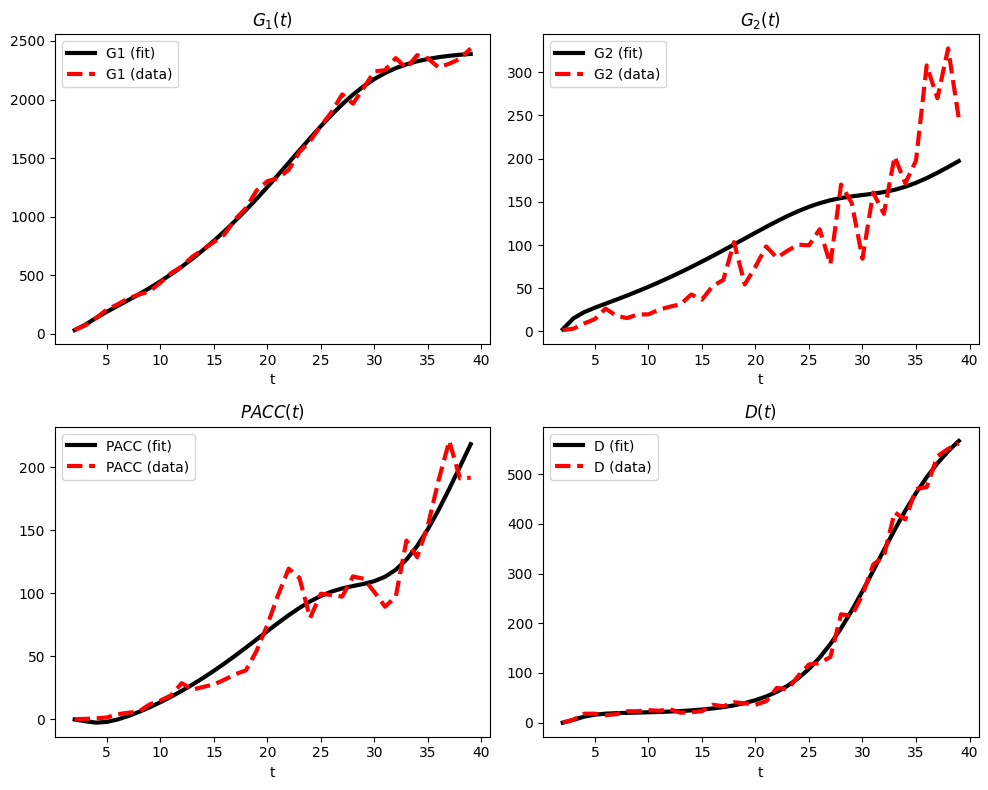

In [8]:
# PINN params
loss_param = pd.read_csv('loss_param_1b.csv')
k1 = loss_param['k1']; k2 = loss_param['k2']; k3 = loss_param['k3']; kd = loss_param['kd']; kd2 = loss_param['kd2']
k1_param = k1[len(k1)-1]; k2_param = k2[len(k2)-1]; k3_param = k3[len(k3)-1]; kd_param = kd[len(kd)-1]; kd2_param = kd2[len(kd2)-1]

print('k1='+str(k1_param))
print('k2='+str(k2_param))
print('k3='+str(k3_param))
print('kd='+str(kd_param))
print('kd2='+str(kd2_param))


fig, ((ax0, ax1),(ax2, ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

ax0.set_title(r'$G_1(t)$',fontsize = 12)
ax0.plot(t, file_G1_pred, 'k-', label='G1 (fit)',linewidth=3.0)
ax0.plot(t, file_G1, 'r--', label='G1 (data)',linewidth=3.0)
ax0.set_xlabel('t',fontsize = 10)
ax0.legend()

ax1.set_title(r'$G_2(t)$',fontsize = 12)
ax1.plot(t, file_G2_pred, 'k-', label='G2 (fit)',linewidth=3.0)
ax1.plot(t, file_G2, 'r--', label='G2 (data)',linewidth=3.0)
ax1.set_xlabel('t',fontsize = 10)
ax1.legend()

ax2.set_title(r'$PACC(t)$',fontsize = 12)
ax2.plot(t, file_P_pred, 'k-', label='PACC (fit)',linewidth=3.0)
ax2.plot(t, file_P, 'r--', label='PACC (data)',linewidth=3.0)
ax2.set_xlabel('t',fontsize = 10)
ax2.legend()

ax3.set_title(r'$D(t)$',fontsize = 12)
ax3.plot(t, file_D_pred, 'k-', label='D (fit) ',linewidth=3.0)
ax3.plot(t, file_D, 'r--', label=r'D (data)',linewidth=3.0)
ax3.set_xlabel('t',fontsize = 10)
ax3.legend()

fig.tight_layout()

plt.show()




In [9]:
# no_GEM 2N
# B_2

file_G1, file_G2, file_P, file_D, file_G1_pred, file_G2_pred, file_P_pred, file_D_pred = drug_dose_param(pd.read_csv('csvs/B_2.csv'),t)


Epoch [200/6000] Loss: 1.06e-01 params: [0.34121796 1.1704954  0.19089311 0.24907444 0.37060174]
Epoch [400/6000] Loss: 4.13e-02 params: [0.21672936 1.280275   0.06838217 0.17919114 0.24058993]
Epoch [600/6000] Loss: 1.45e-02 params: [0.16085042 1.319158   0.02822102 0.1137215  0.14275077]
Epoch [800/6000] Loss: 5.22e-03 params: [0.14048935 1.3263429  0.02571986 0.07175688 0.07858832]
Epoch [1000/6000] Loss: 2.68e-03 params: [0.13275428 1.3191679  0.04142009 0.04780321 0.04244606]
Epoch [1200/6000] Loss: 2.13e-03 params: [0.12989257 1.3043425  0.06467878 0.03578244 0.02491066]
Epoch [1400/6000] Loss: 1.96e-03 params: [0.12948707 1.2849088  0.08934524 0.03044779 0.01753783]
Epoch 01450: reducing learning rate of group 0 to 5.0000e-04.
Epoch [1600/6000] Loss: 1.93e-03 params: [0.12977114 1.2707046  0.10385647 0.02875939 0.01547654]
Epoch [1800/6000] Loss: 1.89e-03 params: [0.12994175 1.2579651  0.11492939 0.02786756 0.01451814]
Epoch [2000/6000] Loss: 1.86e-03 params: [0.13000117 1.24385

k1=0.07811624
k2=0.6804692
k3=0.04793637
kd=0.016710697
kd2=0.00835024


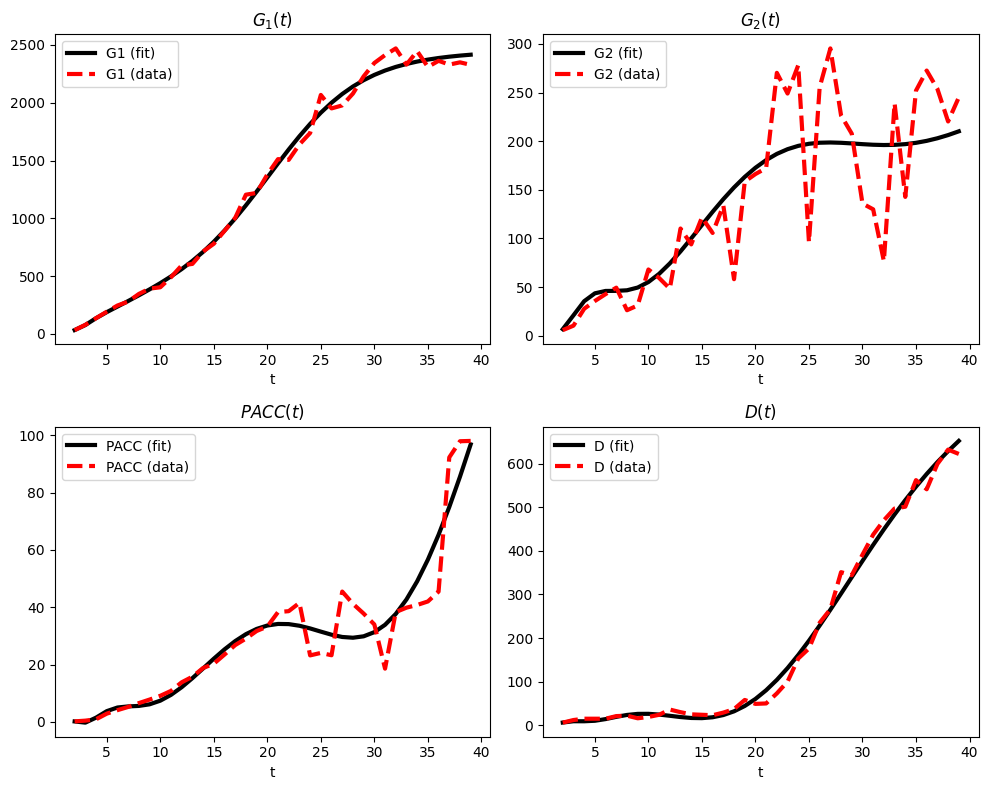

In [10]:
# PINN params
loss_param = pd.read_csv('loss_param_1b.csv')
k1 = loss_param['k1']; k2 = loss_param['k2']; k3 = loss_param['k3']; kd = loss_param['kd']; kd2 = loss_param['kd2']
k1_param = k1[len(k1)-1]; k2_param = k2[len(k2)-1]; k3_param = k3[len(k3)-1]; kd_param = kd[len(kd)-1]; kd2_param = kd2[len(kd2)-1]

print('k1='+str(k1_param))
print('k2='+str(k2_param))
print('k3='+str(k3_param))
print('kd='+str(kd_param))
print('kd2='+str(kd2_param))


fig, ((ax0, ax1),(ax2, ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

ax0.set_title(r'$G_1(t)$',fontsize = 12)
ax0.plot(t, file_G1_pred, 'k-', label='G1 (fit)',linewidth=3.0)
ax0.plot(t, file_G1, 'r--', label='G1 (data)',linewidth=3.0)
ax0.set_xlabel('t',fontsize = 10)
ax0.legend()

ax1.set_title(r'$G_2(t)$',fontsize = 12)
ax1.plot(t, file_G2_pred, 'k-', label='G2 (fit)',linewidth=3.0)
ax1.plot(t, file_G2, 'r--', label='G2 (data)',linewidth=3.0)
ax1.set_xlabel('t',fontsize = 10)
ax1.legend()

ax2.set_title(r'$PACC(t)$',fontsize = 12)
ax2.plot(t, file_P_pred, 'k-', label='PACC (fit)',linewidth=3.0)
ax2.plot(t, file_P, 'r--', label='PACC (data)',linewidth=3.0)
ax2.set_xlabel('t',fontsize = 10)
ax2.legend()

ax3.set_title(r'$D(t)$',fontsize = 12)
ax3.plot(t, file_D_pred, 'k-', label='D (fit) ',linewidth=3.0)
ax3.plot(t, file_D, 'r--', label=r'D (data)',linewidth=3.0)
ax3.set_xlabel('t',fontsize = 10)
ax3.legend()

fig.tight_layout()

plt.show()




In [11]:
# no_GEM 2N
# C_2

file_G1, file_G2, file_P, file_D, file_G1_pred, file_G2_pred, file_P_pred, file_D_pred = drug_dose_param(pd.read_csv('csvs/C_2.csv'),t)


Epoch [200/6000] Loss: 1.51e-01 params: [1.09380536e-01 8.89867008e-01 3.41379317e-04 4.89538491e-01
 3.81070495e-01]
Epoch [400/6000] Loss: 5.04e-02 params: [2.2526789e-02 9.9043053e-01 8.7225722e-05 2.5921094e-01 2.2120467e-01]
Epoch [600/6000] Loss: 1.16e-02 params: [6.7593694e-02 1.0156422e+00 2.1534503e-05 1.1928451e-01 1.0421187e-01]
Epoch [800/6000] Loss: 3.39e-03 params: [9.6309818e-02 1.0188688e+00 2.2666864e-06 5.5063244e-02 4.3007381e-02]
Epoch [1000/6000] Loss: 2.34e-03 params: [0.09948284 1.0134467  0.00647545 0.03193106 0.0199967 ]
Epoch [1200/6000] Loss: 2.18e-03 params: [0.09964451 1.0036435  0.02166999 0.02501472 0.01332422]
Epoch [1400/6000] Loss: 2.10e-03 params: [0.10014562 0.99168503 0.03788656 0.02306758 0.01166119]
Epoch [1600/6000] Loss: 2.03e-03 params: [0.10057797 0.9783293  0.05251849 0.02225666 0.01114531]
Epoch [1800/6000] Loss: 1.98e-03 params: [0.10063884 0.96378684 0.06458967 0.0216437  0.01082976]
Epoch [2000/6000] Loss: 1.94e-03 params: [0.10037143 0.9

k1=0.051135186
k2=0.48824948
k3=1.3264705e-05
kd=0.012132769
kd2=0.006038802


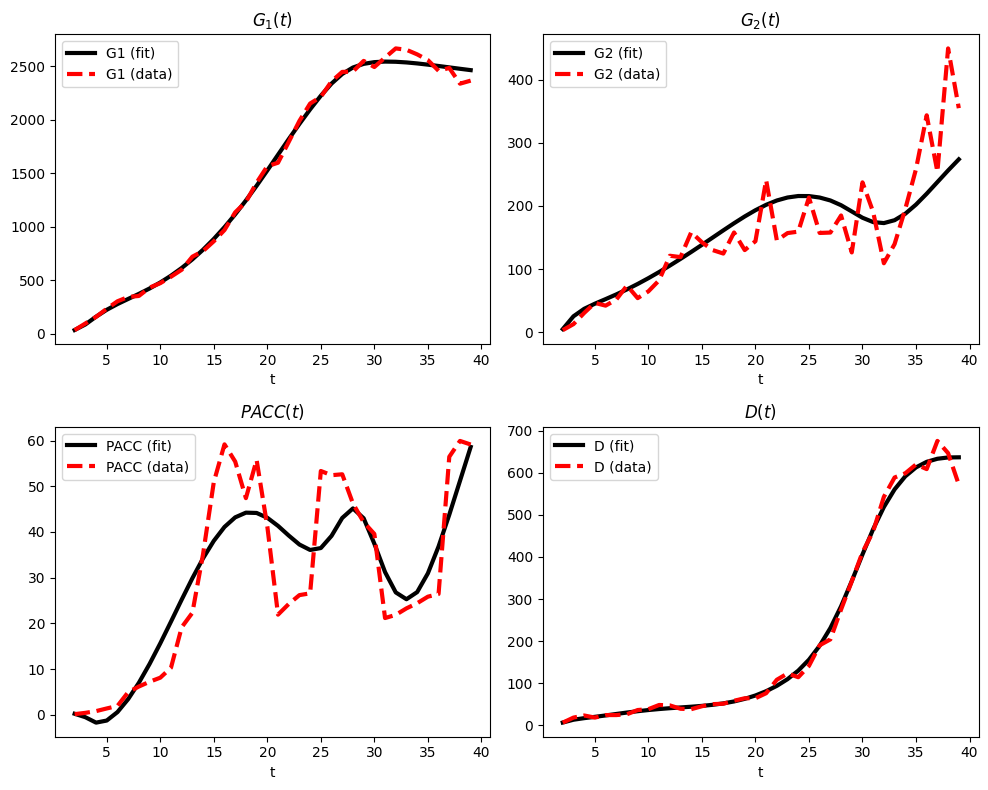

In [12]:
# PINN params
loss_param = pd.read_csv('loss_param_1b.csv')
k1 = loss_param['k1']; k2 = loss_param['k2']; k3 = loss_param['k3']; kd = loss_param['kd']; kd2 = loss_param['kd2']
k1_param = k1[len(k1)-1]; k2_param = k2[len(k2)-1]; k3_param = k3[len(k3)-1]; kd_param = kd[len(kd)-1]; kd2_param = kd2[len(kd2)-1]

print('k1='+str(k1_param))
print('k2='+str(k2_param))
print('k3='+str(k3_param))
print('kd='+str(kd_param))
print('kd2='+str(kd2_param))


fig, ((ax0, ax1),(ax2, ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

ax0.set_title(r'$G_1(t)$',fontsize = 12)
ax0.plot(t, file_G1_pred, 'k-', label='G1 (fit)',linewidth=3.0)
ax0.plot(t, file_G1, 'r--', label='G1 (data)',linewidth=3.0)
ax0.set_xlabel('t',fontsize = 10)
ax0.legend()

ax1.set_title(r'$G_2(t)$',fontsize = 12)
ax1.plot(t, file_G2_pred, 'k-', label='G2 (fit)',linewidth=3.0)
ax1.plot(t, file_G2, 'r--', label='G2 (data)',linewidth=3.0)
ax1.set_xlabel('t',fontsize = 10)
ax1.legend()

ax2.set_title(r'$PACC(t)$',fontsize = 12)
ax2.plot(t, file_P_pred, 'k-', label='PACC (fit)',linewidth=3.0)
ax2.plot(t, file_P, 'r--', label='PACC (data)',linewidth=3.0)
ax2.set_xlabel('t',fontsize = 10)
ax2.legend()

ax3.set_title(r'$D(t)$',fontsize = 12)
ax3.plot(t, file_D_pred, 'k-', label='D (fit) ',linewidth=3.0)
ax3.plot(t, file_D, 'r--', label=r'D (data)',linewidth=3.0)
ax3.set_xlabel('t',fontsize = 10)
ax3.legend()

fig.tight_layout()

plt.show()




In [13]:
# no_GEM 2N
# D_2

file_G1, file_G2, file_P, file_D, file_G1_pred, file_G2_pred, file_P_pred, file_D_pred = drug_dose_param(pd.read_csv('csvs/D_2.csv'),t)


Epoch [200/6000] Loss: 3.35e-01 params: [0.4650404  0.15374792 0.6640459  0.79294693 0.22524688]
Epoch [400/6000] Loss: 2.22e-01 params: [0.21488138 0.41511494 0.59542215 0.6256386  0.2984188 ]
Epoch [600/6000] Loss: 1.18e-01 params: [0.00103432 0.6218289  0.3404837  0.43685848 0.27541244]
Epoch [800/6000] Loss: 4.99e-02 params: [8.0802401e-06 7.3232424e-01 9.6226141e-02 2.6381317e-01 1.9408943e-01]
Epoch [1000/6000] Loss: 1.68e-02 params: [1.2653893e-02 7.7369475e-01 1.8149163e-05 1.4561941e-01 1.1185628e-01]
Epoch [1200/6000] Loss: 6.04e-03 params: [4.7759902e-02 7.8351128e-01 6.6717235e-05 7.7534169e-02 5.7582989e-02]
Epoch [1400/6000] Loss: 3.41e-03 params: [6.8267308e-02 7.8506130e-01 3.1741088e-06 4.3086011e-02 2.9109374e-02]
Epoch [1600/6000] Loss: 2.84e-03 params: [0.07554048 0.78335816 0.00555907 0.02792801 0.01649142]
Epoch [1800/6000] Loss: 2.66e-03 params: [0.07830814 0.7796738  0.02246919 0.02184507 0.01159661]
Epoch [2000/6000] Loss: 2.46e-03 params: [0.08002318 0.7748913

k1=0.06810814
k2=0.62479794
k3=0.06354231
kd=0.014959407
kd2=0.0072695985


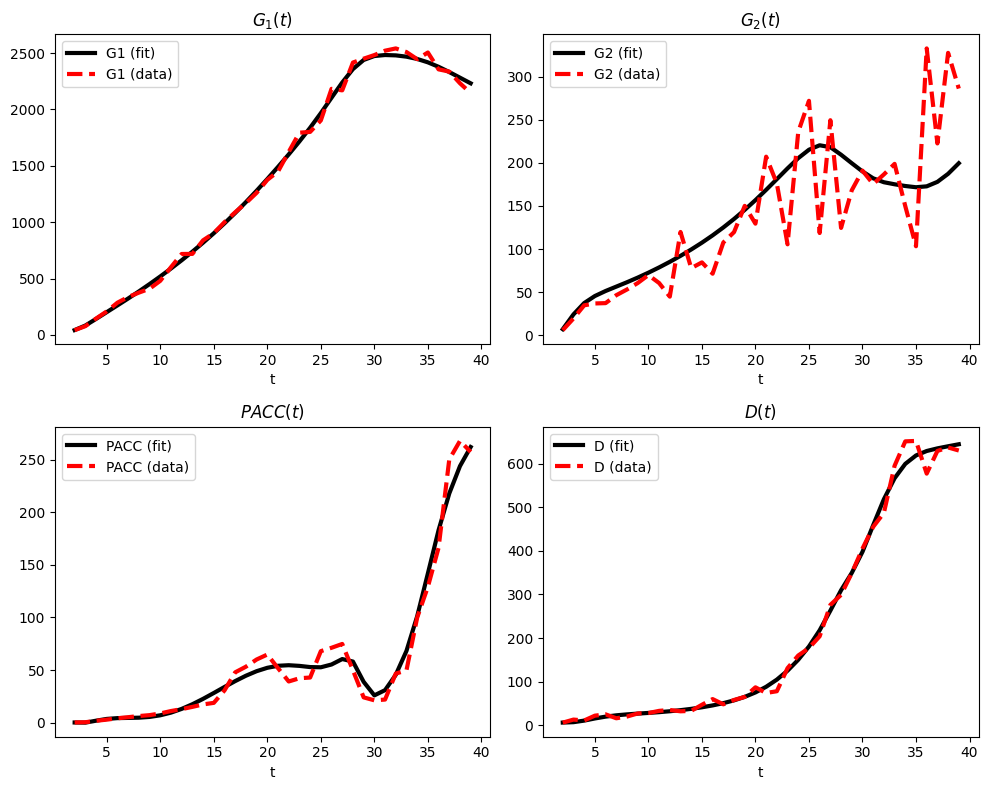

In [14]:
# PINN params
loss_param = pd.read_csv('loss_param_1b.csv')
k1 = loss_param['k1']; k2 = loss_param['k2']; k3 = loss_param['k3']; kd = loss_param['kd']; kd2 = loss_param['kd2']
k1_param = k1[len(k1)-1]; k2_param = k2[len(k2)-1]; k3_param = k3[len(k3)-1]; kd_param = kd[len(kd)-1]; kd2_param = kd2[len(kd2)-1]

print('k1='+str(k1_param))
print('k2='+str(k2_param))
print('k3='+str(k3_param))
print('kd='+str(kd_param))
print('kd2='+str(kd2_param))


fig, ((ax0, ax1),(ax2, ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

ax0.set_title(r'$G_1(t)$',fontsize = 12)
ax0.plot(t, file_G1_pred, 'k-', label='G1 (fit)',linewidth=3.0)
ax0.plot(t, file_G1, 'r--', label='G1 (data)',linewidth=3.0)
ax0.set_xlabel('t',fontsize = 10)
ax0.legend()

ax1.set_title(r'$G_2(t)$',fontsize = 12)
ax1.plot(t, file_G2_pred, 'k-', label='G2 (fit)',linewidth=3.0)
ax1.plot(t, file_G2, 'r--', label='G2 (data)',linewidth=3.0)
ax1.set_xlabel('t',fontsize = 10)
ax1.legend()

ax2.set_title(r'$PACC(t)$',fontsize = 12)
ax2.plot(t, file_P_pred, 'k-', label='PACC (fit)',linewidth=3.0)
ax2.plot(t, file_P, 'r--', label='PACC (data)',linewidth=3.0)
ax2.set_xlabel('t',fontsize = 10)
ax2.legend()

ax3.set_title(r'$D(t)$',fontsize = 12)
ax3.plot(t, file_D_pred, 'k-', label='D (fit) ',linewidth=3.0)
ax3.plot(t, file_D, 'r--', label=r'D (data)',linewidth=3.0)
ax3.set_xlabel('t',fontsize = 10)
ax3.legend()

fig.tight_layout()

plt.show()




### 4N

In [15]:
# no_GEM 4N
# E_2

file_G1, file_G2, file_P, file_D, file_G1_pred, file_G2_pred, file_P_pred, file_D_pred = drug_dose_param(pd.read_csv('csvs/E_2.csv'),t)


Epoch [200/6000] Loss: 5.10e-03 params: [0.00597985 0.86824226 0.20281154 0.07140856 0.03801351]
Epoch [400/6000] Loss: 1.12e-03 params: [0.03215312 0.8982239  0.13966398 0.01222159 0.00643028]
Epoch [600/6000] Loss: 8.81e-04 params: [0.03310557 0.9159473  0.10948309 0.00471395 0.00242124]
Epoch [800/6000] Loss: 8.12e-04 params: [0.03297201 0.9336081  0.08210696 0.00475345 0.00241258]
Epoch 00925: reducing learning rate of group 0 to 5.0000e-04.
Epoch [1000/6000] Loss: 7.74e-04 params: [0.03283848 0.94909275 0.06014455 0.00510427 0.00257484]
Epoch [1200/6000] Loss: 7.45e-04 params: [0.0327716  0.959628   0.04649001 0.00533398 0.00268115]
Epoch [1400/6000] Loss: 7.21e-04 params: [0.0327224  0.97108066 0.03273161 0.00556406 0.00278784]
Epoch [1600/6000] Loss: 7.03e-04 params: [0.03269275 0.9832736  0.01925692 0.00578059 0.00288769]
Epoch [1800/6000] Loss: 6.88e-04 params: [0.03268465 0.996037   0.00640059 0.00597976 0.00297905]
Epoch [2000/6000] Loss: 6.78e-04 params: [3.2847896e-02 1.00

k1=0.03918094
k2=1.2085216
k3=2.4809733e-06
kd=0.0071431114
kd2=0.0035135702


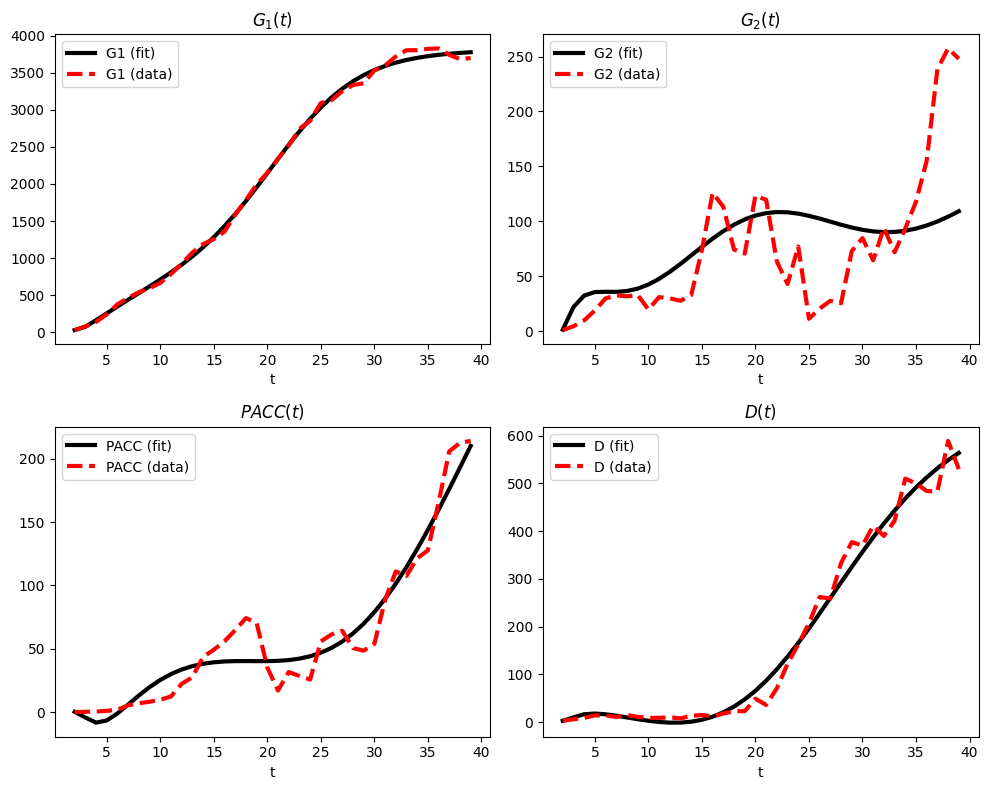

In [16]:
# PINN params
loss_param = pd.read_csv('loss_param_1b.csv')
k1 = loss_param['k1']; k2 = loss_param['k2']; k3 = loss_param['k3']; kd = loss_param['kd']; kd2 = loss_param['kd2']
k1_param = k1[len(k1)-1]; k2_param = k2[len(k2)-1]; k3_param = k3[len(k3)-1]; kd_param = kd[len(kd)-1]; kd2_param = kd2[len(kd2)-1]

print('k1='+str(k1_param))
print('k2='+str(k2_param))
print('k3='+str(k3_param))
print('kd='+str(kd_param))
print('kd2='+str(kd2_param))


fig, ((ax0, ax1),(ax2, ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

ax0.set_title(r'$G_1(t)$',fontsize = 12)
ax0.plot(t, file_G1_pred, 'k-', label='G1 (fit)',linewidth=3.0)
ax0.plot(t, file_G1, 'r--', label='G1 (data)',linewidth=3.0)
ax0.set_xlabel('t',fontsize = 10)
ax0.legend()

ax1.set_title(r'$G_2(t)$',fontsize = 12)
ax1.plot(t, file_G2_pred, 'k-', label='G2 (fit)',linewidth=3.0)
ax1.plot(t, file_G2, 'r--', label='G2 (data)',linewidth=3.0)
ax1.set_xlabel('t',fontsize = 10)
ax1.legend()

ax2.set_title(r'$PACC(t)$',fontsize = 12)
ax2.plot(t, file_P_pred, 'k-', label='PACC (fit)',linewidth=3.0)
ax2.plot(t, file_P, 'r--', label='PACC (data)',linewidth=3.0)
ax2.set_xlabel('t',fontsize = 10)
ax2.legend()

ax3.set_title(r'$D(t)$',fontsize = 12)
ax3.plot(t, file_D_pred, 'k-', label='D (fit) ',linewidth=3.0)
ax3.plot(t, file_D, 'r--', label=r'D (data)',linewidth=3.0)
ax3.set_xlabel('t',fontsize = 10)
ax3.legend()

fig.tight_layout()

plt.show()




In [17]:
# no_GEM 4N
# F_2

file_G1, file_G2, file_P, file_D, file_G1_pred, file_G2_pred, file_P_pred, file_D_pred = drug_dose_param(pd.read_csv('csvs/F_2.csv'),t)


Epoch [200/6000] Loss: 1.63e-01 params: [0.69550705 0.6323241  0.27988592 0.29979557 0.14588742]
Epoch [400/6000] Loss: 5.93e-02 params: [0.49814487 0.7886173  0.2452675  0.14200258 0.09704618]
Epoch [600/6000] Loss: 1.88e-02 params: [0.3383455  0.87058944 0.2766276  0.05508637 0.03856383]
Epoch [800/6000] Loss: 6.77e-03 params: [0.2253852  0.90672195 0.30168435 0.01975185 0.01345993]
Epoch [1000/6000] Loss: 3.04e-03 params: [0.15211788 0.9220555  0.30868274 0.00826442 0.0052861 ]
Epoch [1200/6000] Loss: 1.95e-03 params: [0.10911933 0.92860186 0.30388385 0.00562231 0.00323856]
Epoch [1400/6000] Loss: 1.64e-03 params: [0.08659581 0.9315342  0.29282418 0.00555957 0.00300693]
Epoch [1600/6000] Loss: 1.90e-03 params: [0.07617925 0.9329621  0.27846637 0.0059841  0.0031607 ]
Epoch [1800/6000] Loss: 1.50e-03 params: [0.07193262 0.93373823 0.2623202  0.00640427 0.0033373 ]
Epoch 01914: reducing learning rate of group 0 to 5.0000e-04.
Epoch [2000/6000] Loss: 1.48e-03 params: [0.07048095 0.93414

k1=0.06460599
k2=0.93104225
k3=0.11252155
kd=0.008868034
kd2=0.004382123


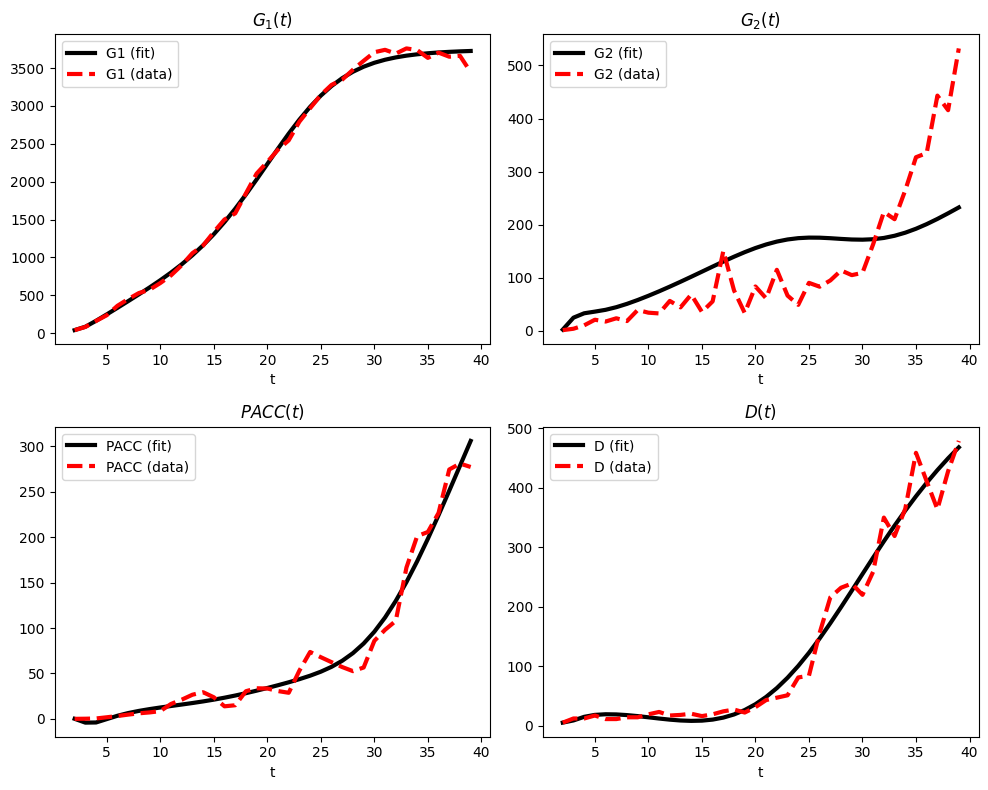

In [18]:
# PINN params
loss_param = pd.read_csv('loss_param_1b.csv')
k1 = loss_param['k1']; k2 = loss_param['k2']; k3 = loss_param['k3']; kd = loss_param['kd']; kd2 = loss_param['kd2']
k1_param = k1[len(k1)-1]; k2_param = k2[len(k2)-1]; k3_param = k3[len(k3)-1]; kd_param = kd[len(kd)-1]; kd2_param = kd2[len(kd2)-1]

print('k1='+str(k1_param))
print('k2='+str(k2_param))
print('k3='+str(k3_param))
print('kd='+str(kd_param))
print('kd2='+str(kd2_param))


fig, ((ax0, ax1),(ax2, ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

ax0.set_title(r'$G_1(t)$',fontsize = 12)
ax0.plot(t, file_G1_pred, 'k-', label='G1 (fit)',linewidth=3.0)
ax0.plot(t, file_G1, 'r--', label='G1 (data)',linewidth=3.0)
ax0.set_xlabel('t',fontsize = 10)
ax0.legend()

ax1.set_title(r'$G_2(t)$',fontsize = 12)
ax1.plot(t, file_G2_pred, 'k-', label='G2 (fit)',linewidth=3.0)
ax1.plot(t, file_G2, 'r--', label='G2 (data)',linewidth=3.0)
ax1.set_xlabel('t',fontsize = 10)
ax1.legend()

ax2.set_title(r'$PACC(t)$',fontsize = 12)
ax2.plot(t, file_P_pred, 'k-', label='PACC (fit)',linewidth=3.0)
ax2.plot(t, file_P, 'r--', label='PACC (data)',linewidth=3.0)
ax2.set_xlabel('t',fontsize = 10)
ax2.legend()

ax3.set_title(r'$D(t)$',fontsize = 12)
ax3.plot(t, file_D_pred, 'k-', label='D (fit) ',linewidth=3.0)
ax3.plot(t, file_D, 'r--', label=r'D (data)',linewidth=3.0)
ax3.set_xlabel('t',fontsize = 10)
ax3.legend()

fig.tight_layout()

plt.show()




In [19]:
# no_GEM 4N
# G_2

file_G1, file_G2, file_P, file_D, file_G1_pred, file_G2_pred, file_P_pred, file_D_pred = drug_dose_param(pd.read_csv('csvs/G_2.csv'),t)


Epoch [200/6000] Loss: 4.80e-01 params: [6.5550303e-01 9.7152680e-01 4.1296007e-05 4.6776456e-01 7.9354656e-01]
Epoch [400/6000] Loss: 3.08e-01 params: [4.7849208e-01 1.1343966e+00 4.2005515e-05 5.2250719e-01 6.4518166e-01]
Epoch [600/6000] Loss: 2.09e-01 params: [3.2814792e-01 1.2599159e+00 3.0648975e-05 4.7491336e-01 5.2287912e-01]
Epoch [800/6000] Loss: 1.30e-01 params: [2.0752986e-01 1.3489745e+00 2.1162490e-05 3.5673258e-01 4.1203088e-01]
Epoch [1000/6000] Loss: 7.00e-02 params: [1.3244191e-01 1.3991084e+00 1.7883609e-05 2.4061854e-01 3.0668336e-01]
Epoch [1200/6000] Loss: 3.38e-02 params: [9.7186498e-02 1.4233074e+00 6.5418681e-07 1.5927266e-01 2.1400946e-01]
Epoch [1400/6000] Loss: 1.51e-02 params: [8.1990913e-02 1.4351586e+00 7.2424377e-06 1.0494179e-01 1.4081734e-01]
Epoch [1600/6000] Loss: 6.96e-03 params: [7.3469631e-02 1.4412051e+00 9.7868233e-06 6.8253741e-02 8.7920323e-02]
Epoch [1800/6000] Loss: 2.77e-03 params: [6.6818900e-02 1.4442687e+00 1.1313152e-06 4.3926492e-02 5.

k1=0.05589938
k2=1.4374719
k3=0.050692756
kd=0.00938431
kd2=0.004546016


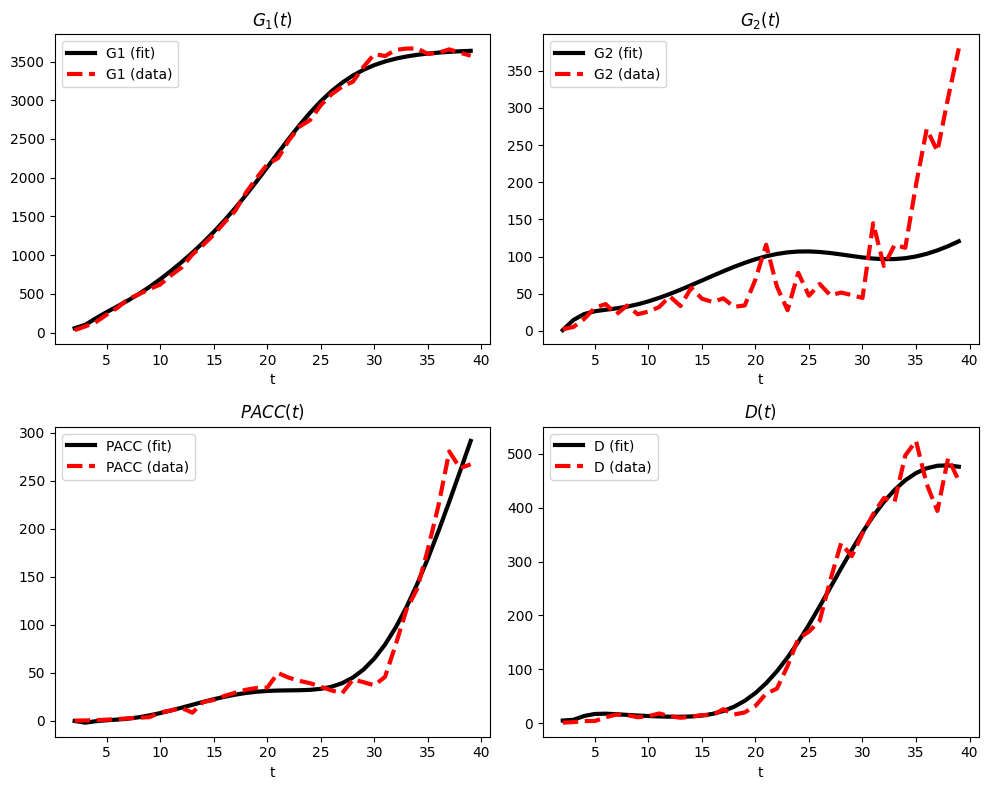

In [20]:
# PINN params
loss_param = pd.read_csv('loss_param_1b.csv')
k1 = loss_param['k1']; k2 = loss_param['k2']; k3 = loss_param['k3']; kd = loss_param['kd']; kd2 = loss_param['kd2']
k1_param = k1[len(k1)-1]; k2_param = k2[len(k2)-1]; k3_param = k3[len(k3)-1]; kd_param = kd[len(kd)-1]; kd2_param = kd2[len(kd2)-1]

print('k1='+str(k1_param))
print('k2='+str(k2_param))
print('k3='+str(k3_param))
print('kd='+str(kd_param))
print('kd2='+str(kd2_param))


fig, ((ax0, ax1),(ax2, ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

ax0.set_title(r'$G_1(t)$',fontsize = 12)
ax0.plot(t, file_G1_pred, 'k-', label='G1 (fit)',linewidth=3.0)
ax0.plot(t, file_G1, 'r--', label='G1 (data)',linewidth=3.0)
ax0.set_xlabel('t',fontsize = 10)
ax0.legend()

ax1.set_title(r'$G_2(t)$',fontsize = 12)
ax1.plot(t, file_G2_pred, 'k-', label='G2 (fit)',linewidth=3.0)
ax1.plot(t, file_G2, 'r--', label='G2 (data)',linewidth=3.0)
ax1.set_xlabel('t',fontsize = 10)
ax1.legend()

ax2.set_title(r'$PACC(t)$',fontsize = 12)
ax2.plot(t, file_P_pred, 'k-', label='PACC (fit)',linewidth=3.0)
ax2.plot(t, file_P, 'r--', label='PACC (data)',linewidth=3.0)
ax2.set_xlabel('t',fontsize = 10)
ax2.legend()

ax3.set_title(r'$D(t)$',fontsize = 12)
ax3.plot(t, file_D_pred, 'k-', label='D (fit) ',linewidth=3.0)
ax3.plot(t, file_D, 'r--', label=r'D (data)',linewidth=3.0)
ax3.set_xlabel('t',fontsize = 10)
ax3.legend()

fig.tight_layout()

plt.show()




In [21]:
# no_GEM 4N
# H_2

file_G1, file_G2, file_P, file_D, file_G1_pred, file_G2_pred, file_P_pred, file_D_pred = drug_dose_param(pd.read_csv('csvs/H_2.csv'),t)


Epoch [200/6000] Loss: 3.78e-01 params: [0.36708635 0.5078487  0.0927166  0.40754855 0.6922031 ]
Epoch [400/6000] Loss: 2.25e-01 params: [1.9335955e-01 6.4837044e-01 4.5634035e-05 4.4719929e-01 5.4789901e-01]
Epoch [600/6000] Loss: 1.39e-01 params: [5.5138797e-02 7.4230337e-01 2.0904196e-04 3.8277224e-01 4.2981020e-01]
Epoch [800/6000] Loss: 7.89e-02 params: [6.9894013e-06 7.9209286e-01 5.8331923e-05 2.7306306e-01 3.2353917e-01]
Epoch [1000/6000] Loss: 4.20e-02 params: [1.2948595e-05 8.1934428e-01 4.0504765e-06 1.7770498e-01 2.2782411e-01]
Epoch [1200/6000] Loss: 1.76e-02 params: [5.6838914e-04 8.3277214e-01 1.0908432e-05 1.1297694e-01 1.4942576e-01]
Epoch [1400/6000] Loss: 7.34e-03 params: [1.06104845e-02 8.39318395e-01 3.43568026e-05 6.93822503e-02
 9.16938484e-02]
Epoch [1600/6000] Loss: 3.17e-03 params: [2.1209607e-02 8.4335619e-01 1.8606252e-06 4.0414672e-02 5.2639429e-02]
Epoch [1800/6000] Loss: 1.71e-03 params: [2.7383575e-02 8.4627879e-01 5.6813105e-06 2.2370804e-02 2.8253332e-

k1=0.03183698
k2=0.85302514
k3=2.699121e-07
kd=0.0034892266
kd2=0.0029570158


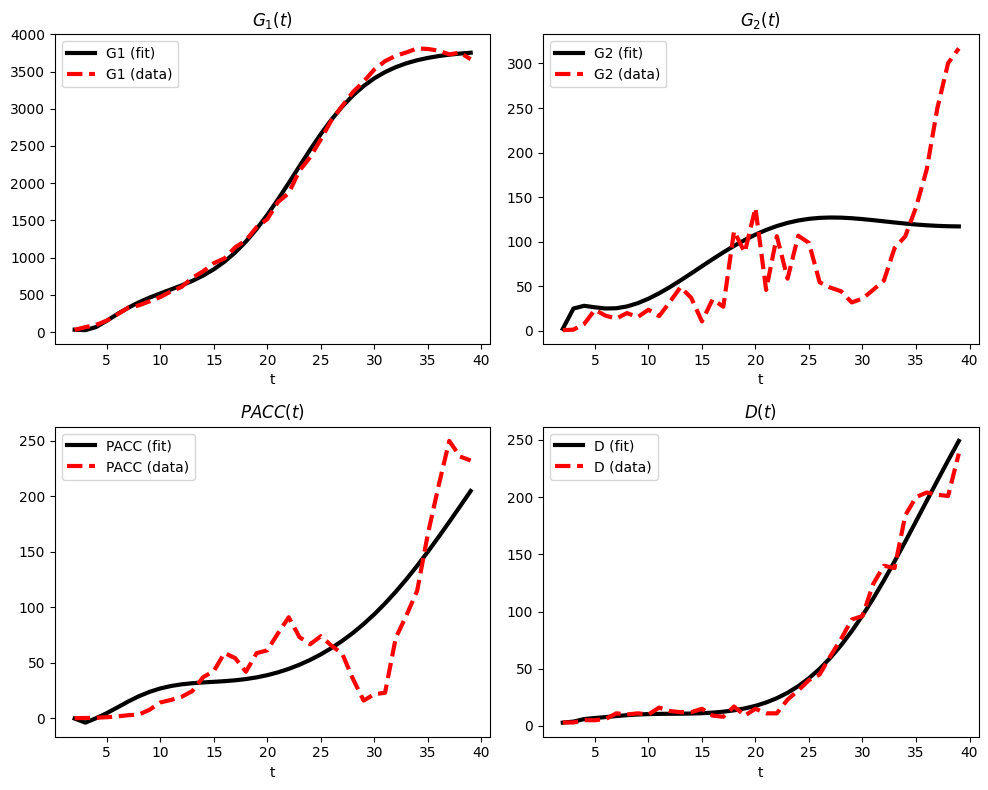

In [22]:
# PINN params
loss_param = pd.read_csv('loss_param_1b.csv')
k1 = loss_param['k1']; k2 = loss_param['k2']; k3 = loss_param['k3']; kd = loss_param['kd']; kd2 = loss_param['kd2']
k1_param = k1[len(k1)-1]; k2_param = k2[len(k2)-1]; k3_param = k3[len(k3)-1]; kd_param = kd[len(kd)-1]; kd2_param = kd2[len(kd2)-1]

print('k1='+str(k1_param))
print('k2='+str(k2_param))
print('k3='+str(k3_param))
print('kd='+str(kd_param))
print('kd2='+str(kd2_param))


fig, ((ax0, ax1),(ax2, ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

ax0.set_title(r'$G_1(t)$',fontsize = 12)
ax0.plot(t, file_G1_pred, 'k-', label='G1 (fit)',linewidth=3.0)
ax0.plot(t, file_G1, 'r--', label='G1 (data)',linewidth=3.0)
ax0.set_xlabel('t',fontsize = 10)
ax0.legend()

ax1.set_title(r'$G_2(t)$',fontsize = 12)
ax1.plot(t, file_G2_pred, 'k-', label='G2 (fit)',linewidth=3.0)
ax1.plot(t, file_G2, 'r--', label='G2 (data)',linewidth=3.0)
ax1.set_xlabel('t',fontsize = 10)
ax1.legend()

ax2.set_title(r'$PACC(t)$',fontsize = 12)
ax2.plot(t, file_P_pred, 'k-', label='PACC (fit)',linewidth=3.0)
ax2.plot(t, file_P, 'r--', label='PACC (data)',linewidth=3.0)
ax2.set_xlabel('t',fontsize = 10)
ax2.legend()

ax3.set_title(r'$D(t)$',fontsize = 12)
ax3.plot(t, file_D_pred, 'k-', label='D (fit) ',linewidth=3.0)
ax3.plot(t, file_D, 'r--', label=r'D (data)',linewidth=3.0)
ax3.set_xlabel('t',fontsize = 10)
ax3.legend()

fig.tight_layout()

plt.show()




In [30]:
# k1 2N
k1_2N_UNTX  = np.array([0.06274018,0.07811624,0.051135186,0.06810814])

# k1 4N
k1_4N_UNTX  = np.array([0.03918094,0.06460599,0.05589938,0.03183698])

# k2 2N
k2_2N_UNTX  = np.array([0.68131554,0.6804692,0.48824948,0.62479794])

# k2 4N
k2_4N_UNTX  = np.array([1.2085216,0.93104225,1.4374719,0.85302514])

# k3 2N
k3_2N_UNTX  = np.array([0.057338193,0.04793637,1.3264705e-05,0.06354231])

# k3 4N
k3_4N_UNTX  = np.array([2.4809733e-06,0.11252155,0.050692756,2.699121e-07])

# kd 2N
kd_2N_UNTX  = np.array([0.012247945,0.016710697,0.012132769,0.014959407])

# kd 4N
kd_4N_UNTX  = np.array([0.0071431114,0.008868034,0.00938431,0.0034892266])

# kd2 2N
kd2_2N_UNTX  = np.array([0.0060835117,0.00835024,0.006038802,0.0072695985])

# kd2 4N
kd2_4N_UNTX  = np.array([0.0035135702,0.004382123,0.004546016,0.0029570158])

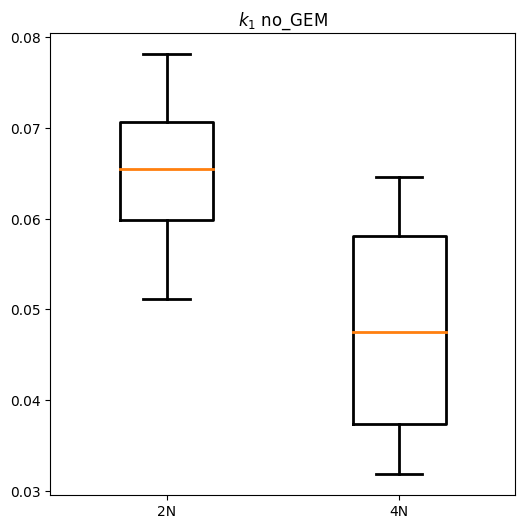

In [31]:
# creating box plots

# Create a boxplot for each array on the same plot
plt.figure(figsize=(6, 6))
boxprops = dict(linewidth=2)  # Bold box lines
whiskerprops = dict(linewidth=2)  # Bold whisker lines
capprops = dict(linewidth=2)  # Bold cap lines
medianprops = dict(linewidth=2)  # Bold median line

plt.boxplot([k1_2N_UNTX, k1_4N_UNTX], labels=['2N', '4N'], widths=0.4,
            boxprops=boxprops, whiskerprops=whiskerprops,
            capprops=capprops, medianprops=medianprops)
# plt.ylabel("Values")
plt.title(r"$k_1$ no_GEM")
plt.show()

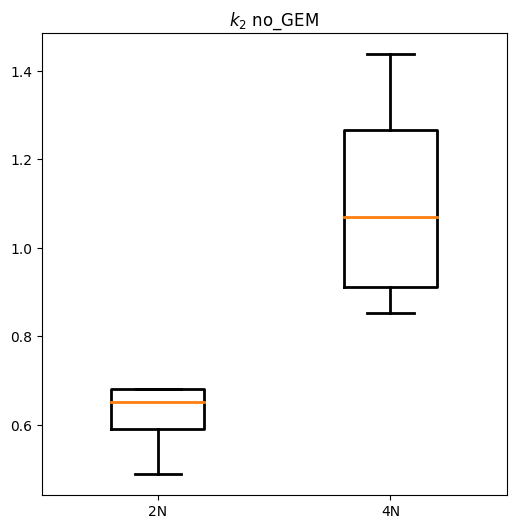

In [32]:
# creating box plots

# Create a boxplot for each array on the same plot
plt.figure(figsize=(6, 6))
boxprops = dict(linewidth=2)  # Bold box lines
whiskerprops = dict(linewidth=2)  # Bold whisker lines
capprops = dict(linewidth=2)  # Bold cap lines
medianprops = dict(linewidth=2)  # Bold median line

plt.boxplot([k2_2N_UNTX, k2_4N_UNTX], labels=['2N', '4N'], widths=0.4,
            boxprops=boxprops, whiskerprops=whiskerprops,
            capprops=capprops, medianprops=medianprops)
# plt.ylabel("Values")
plt.title(r"$k_2$ no_GEM")
plt.show()

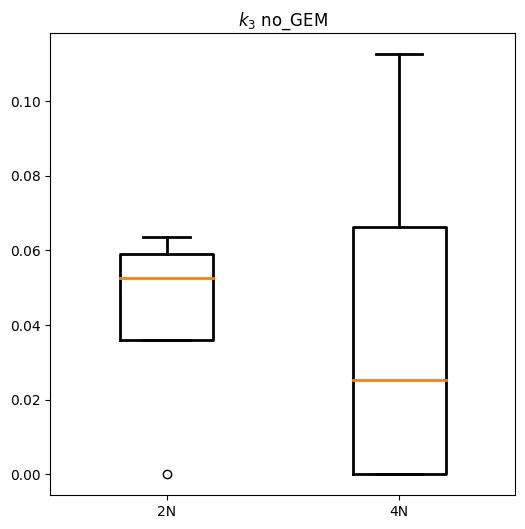

In [33]:
# creating box plots

# Create a boxplot for each array on the same plot
plt.figure(figsize=(6, 6))
boxprops = dict(linewidth=2)  # Bold box lines
whiskerprops = dict(linewidth=2)  # Bold whisker lines
capprops = dict(linewidth=2)  # Bold cap lines
medianprops = dict(linewidth=2)  # Bold median line

plt.boxplot([k3_2N_UNTX, k3_4N_UNTX], labels=['2N', '4N'], widths=0.4,
            boxprops=boxprops, whiskerprops=whiskerprops,
            capprops=capprops, medianprops=medianprops)
# plt.ylabel("Values")
plt.title(r"$k_3$ no_GEM")
plt.show()

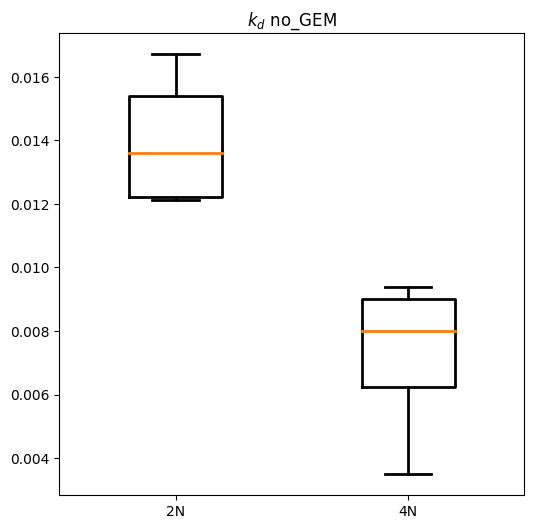

In [34]:
# creating box plots

# Create a boxplot for each array on the same plot
plt.figure(figsize=(6, 6))
boxprops = dict(linewidth=2)  # Bold box lines
whiskerprops = dict(linewidth=2)  # Bold whisker lines
capprops = dict(linewidth=2)  # Bold cap lines
medianprops = dict(linewidth=2)  # Bold median line

plt.boxplot([kd_2N_UNTX, kd_4N_UNTX], labels=['2N', '4N'], widths=0.4,
            boxprops=boxprops, whiskerprops=whiskerprops,
            capprops=capprops, medianprops=medianprops)
# plt.ylabel("Values")
plt.title(r"$k_d$ no_GEM")
plt.show()

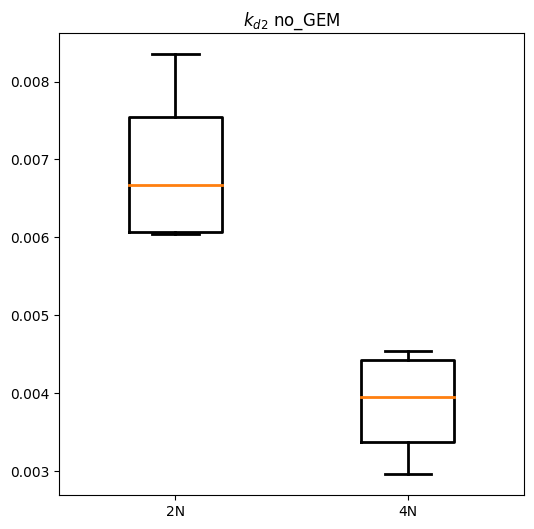

In [35]:
# creating box plots

# Create a boxplot for each array on the same plot
plt.figure(figsize=(6, 6))
boxprops = dict(linewidth=2)  # Bold box lines
whiskerprops = dict(linewidth=2)  # Bold whisker lines
capprops = dict(linewidth=2)  # Bold cap lines
medianprops = dict(linewidth=2)  # Bold median line

plt.boxplot([kd2_2N_UNTX, kd2_4N_UNTX], labels=['2N', '4N'], widths=0.4,
            boxprops=boxprops, whiskerprops=whiskerprops,
            capprops=capprops, medianprops=medianprops)
# plt.ylabel("Values")
plt.title(r"$k_{d2}$ no_GEM")
plt.show()

In [42]:
# mean k1 2N
k1_2N_median = np.median(k1_2N_UNTX)

# mean k2 2N
k2_2N_median = np.median(k2_2N_UNTX)

# mean k3 2N
k3_2N_median = np.median(k3_2N_UNTX)

# mean kd 2N
kd_2N_median = np.median(kd_2N_UNTX)

# mean kd2 2N
kd2_2N_median = np.median(kd2_2N_UNTX)

In [43]:
# mean k1 4N
k1_4N_median = np.median(k1_4N_UNTX)

# mean k2 4N
k2_4N_median = np.median(k2_4N_UNTX)

# mean k3 4N
k3_4N_median = np.median(k3_4N_UNTX)

# mean kd 4N
kd_4N_median = np.median(kd_4N_UNTX)

# mean kd2 4N
kd2_4N_median = np.median(kd2_4N_UNTX)

In [44]:
kn_param_2N = np.array([k1_2N_median, k2_2N_median, k3_2N_median, kd_2N_median, kd2_2N_median])

print(kn_param_2N)

[0.06542416 0.65263357 0.05263728 0.01360368 0.00667656]


In [45]:
kn_param_4N = np.array([k1_4N_median, k2_4N_median, k3_4N_median, kd_4N_median, kd2_4N_median])

print(kn_param_4N)

[0.04754016 1.06978193 0.02534762 0.00800557 0.00394785]
